In [1]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.colors import DivergingNorm
from collections import Counter

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


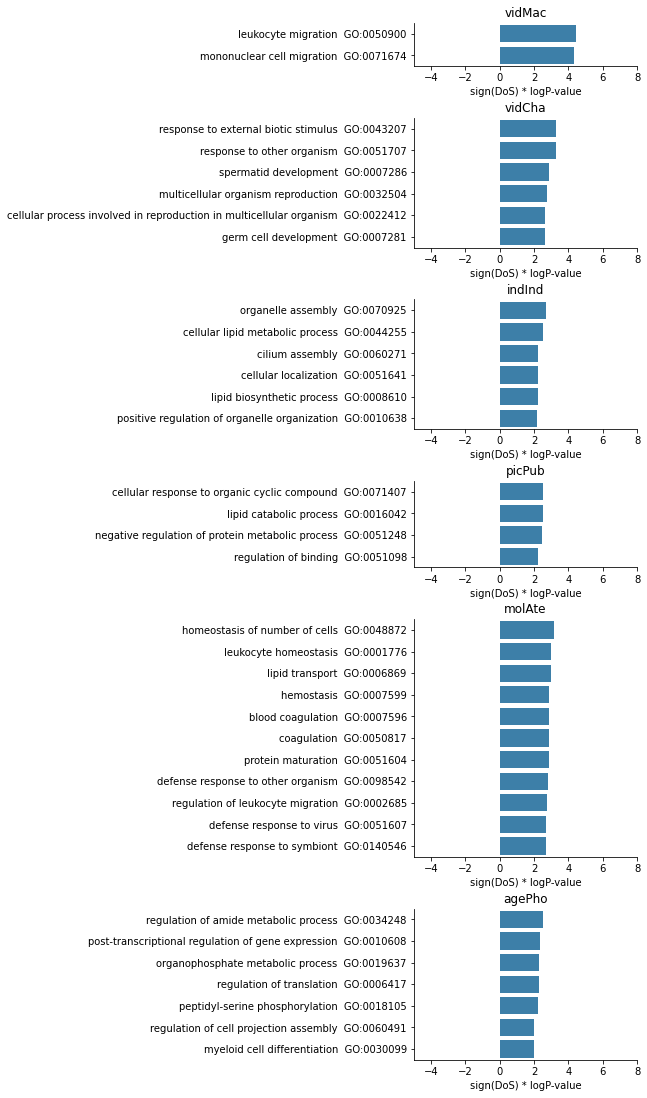

In [2]:
## GSEA from clusterProfiler
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
# dbs = ['vidMac', 'vidCha', 'anoImb', 'molAte', 'agePho', 'picPub']
dbs = ['anoImb', 'vidMac', 'vidCha', 'indInd', 'picPub', 'molAte', 'agePho', 'taeGut', 'poeAcu']

## Load data
DF_dbs = {}
for db in dbs:
    file_name = 'MK_test_{}_ncbi/impMKT/gse.tsv'.format(db)
    file_data = glob(dir_path + file_name)[0]
    df = pd.read_csv(file_data, sep='\t')

    df['GOfull'] = df['Description'] + '  ' + df['ID']
    df['logpval'] = - np.log10(df['pvalue'])
    dos = [1 if x > 0 else -1 for x in df['NES']]
    df['dos'] = dos
    df['sign_logP'] = df['logpval'] * dos
    df.sort_values(by=['sign_logP'], inplace=True, ascending=False)
    DF_dbs[db] = df


## Plot barplots p-value DoS > 0 and DoS < 0
db_ratios = [DF_dbs[db].shape[0] for db in dbs]

fig, axes = plt.subplots(len(dbs), 1, gridspec_kw={'height_ratios': db_ratios}, figsize=(4, 4*len(dbs)))

i = 0
for db in dbs:
    axi = axes[i]
    sns.set_palette(['#2b83ba', '#d7191c'])
    df = DF_dbs[db]
    sns.barplot(ax=axi, data=df, x='sign_logP', y='GOfull', hue='dos', dodge=False)
    axi.set_xlim(-5, 8)
    axi.set(xlabel='sign(DoS) * logP-value', ylabel='')
    axi.legend([], [], frameon=False)
    axi.set_title(db)
    i += 1
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.subplots_adjust(bottom=0, top=0.6, wspace=0, hspace=0.4)
fig.tight_layout()  

pdf_name = 'gsea_top_terms.{}clades.clusterProfiler.pdf'.format(len(dbs))
# fig.savefig(pdf_name, bbox_inches='tight')

MK_test_vidMac_ncbi/impMKT/pos.enrichGO.all_genes_BG.tsv
yes
MK_test_vidCha_ncbi/impMKT/pos.enrichGO.all_genes_BG.tsv
yes
MK_test_anoImb_ncbi/impMKT/pos.enrichGO.all_genes_BG.tsv
yes
MK_test_poeAcu_ncbi/impMKT/pos.enrichGO.all_genes_BG.tsv
yes
MK_test_indInd_ncbi/impMKT/pos.enrichGO.all_genes_BG.tsv
yes
MK_test_picPub_ncbi/impMKT/pos.enrichGO.all_genes_BG.tsv
yes
MK_test_molAte_ncbi/impMKT/pos.enrichGO.all_genes_BG.tsv
yes
MK_test_agePho_ncbi/impMKT/pos.enrichGO.all_genes_BG.tsv


/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


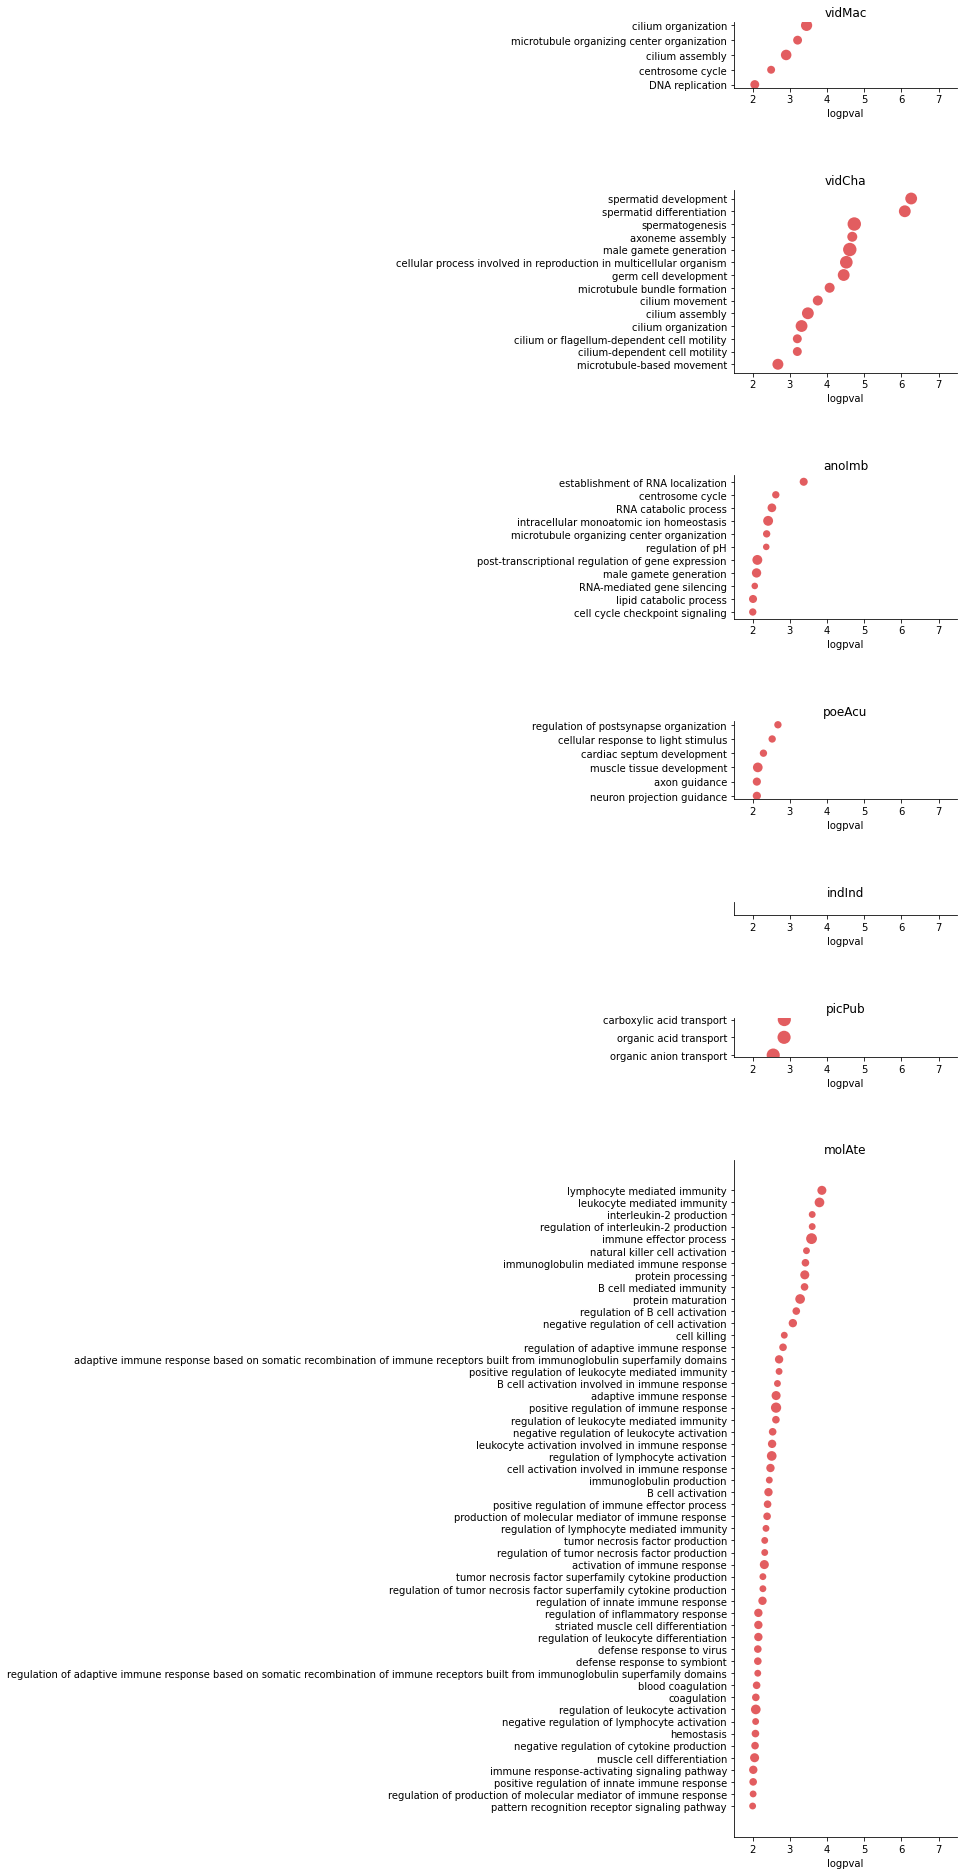

In [3]:
## GO Enrichment MKT. ClusterProfiler
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
# dbs = ['vidMac', 'vidCha', 'anoImb', 'molAte', 'agePho', 'indInd', 'picPub']
dbs = ['vidMac', 'vidCha', 'anoImb', 'poeAcu', 'indInd', 'picPub', 'molAte', 'agePho']


## DoS > 0 or < 0?
dos = 'pos'
# dos = 'neg'

# q_cutoff = 0.5
count_cutoff = 4
# count_cutoff = 3

## Load data
DF_dbs = {}
nonzero_dbs = []
for db in dbs:
    file_name = 'MK_test_{}_ncbi/impMKT/{}.enrichGO.all_genes_BG.tsv'.format(db, dos)
    print(file_name)
    file_data = glob(dir_path + file_name)[0]
    df = pd.read_csv(file_data, sep='\t')
#     df = df[df['qvalue'] < q_cutoff]
    df = df[df['Count'] >= count_cutoff]
    
    if df.shape[0] > 0:
        print('yes')
        df['GOfull'] = df['Description'] + '  ' + df['ID']
        df['logpval'] = - np.log10(df['pvalue'])
        df['ngenes'], df['nset'] = df['GeneRatio'].str.split('/').str
        df['ratio'] = (pd.to_numeric(df['ngenes']) / pd.to_numeric(df['nset']) * 1000).astype(int)
        DF_dbs[db] = df
        nonzero_dbs.append(db)


## Plot barplots p-value DoS > 0 and DoS < 0
db_ratios = [DF_dbs[db].shape[0] for db in nonzero_dbs]
fig, axes = plt.subplots(len(nonzero_dbs), 1, gridspec_kw={'height_ratios': db_ratios}, 
                         figsize=(4, 6*len(nonzero_dbs)))

blue = '#2b83ba'
red = '#d7191c'
if dos == 'pos':
    c = red
elif dos == 'neg':
    c = blue

i = 0
for db in nonzero_dbs:
    axi = axes[i]
    dfi = DF_dbs[db]
    sns.scatterplot(ax=axi, data=dfi, x='logpval', y='Description', size='ratio',
                    sizes=(min(dfi['ratio']), max(dfi['ratio'])), color=c, alpha=0.7, linewidth=0)
    axi.set(xlim=(1.5, 7.5), ylabel='')
    axi.set_title(db)
    axi.legend([], [], frameon=False)
    i += 1
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False) 
fig.subplots_adjust(bottom=0, top=0.6, wspace=0, hspace=0.6)
fig.tight_layout()

pdf_name = 'impMKT.{}.enrichGO.all_genes_BG.pval_0.01.clusterProfiler.pdf'.format(dos, len(dbs))
# fig.savefig(pdf_name, bbox_inches='tight')

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  if sys.path[0] == '':
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


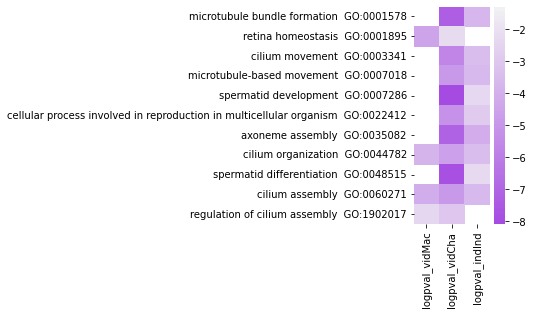

In [99]:
### Make a heatmap for convergent terms

file_name = 'go_convergent_2clades.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')
df.set_index('Description', inplace=True)

for pval_col in pval_cols:
    df['log'+pval_col] = np.log10(df[pval_col])

cmap = sns.diverging_palette(285, 200, 80, as_cmap=True)
divnorm_pval = DivergingNorm(vmax=0, vcenter=np.log10(0.051))

logpval_cols = [i for i in df.columns if i.startswith('logpval')]
df_pval = df[logpval_cols]

fig, axes = plt.subplots(figsize=(1.7, 4))
sns.heatmap(data=df_pval, cmap=cmap, norm=divnorm)
axes.set_ylabel('')
fig.tight_layout()

pdf_name = 'convergence.pos.goEnrich.2_and_more_clades.p0.1.pdf'

# plt.savefig(pdf_name, format='pdf', bbox_inches="tight")

PopGen_vidMac/overlap_CNEE.SF2.go_enrich.1Mb_domain.tsv
yes
PopGen_vidCha/overlap_CNEE.SF2.go_enrich.1Mb_domain.tsv
yes
PopGen_anoImb/overlap_CNEE.SF2.go_enrich.1Mb_domain.tsv
PopGen_indInd/overlap_CNEE.SF2.go_enrich.1Mb_domain.tsv
yes
PopGen_picPub/overlap_CNEE.SF2.go_enrich.1Mb_domain.tsv
yes
PopGen_molAte/overlap_CNEE.SF2.go_enrich.1Mb_domain.tsv
PopGen_agePho/overlap_CNEE.SF2.go_enrich.1Mb_domain.tsv


/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


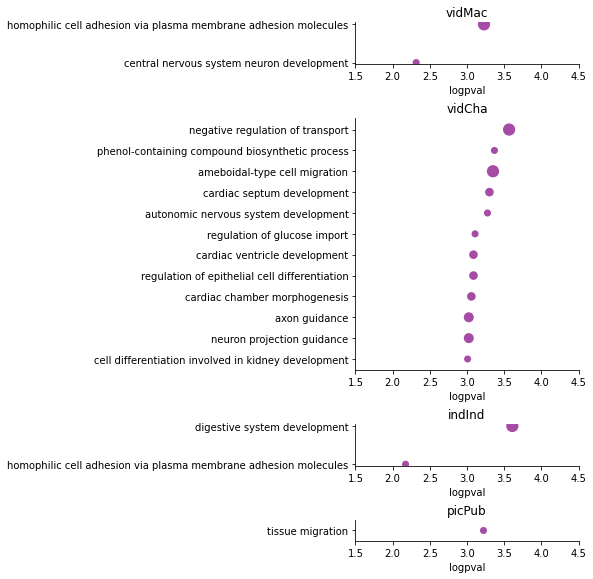

In [8]:
## GO Enrichmens SweepFinder2. ClusterProfiler
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
dbs = ['vidMac', 'vidCha', 'anoImb', 'indInd', 'picPub', 'molAte', 'agePho']

# q_cutoff = 0.5
count_cutoff = 4
count_cutoff = 3

## Load data
DF_dbs = {}
nonzero_dbs = []
for db in dbs:
#     file_name = 'PopGen_{}/SF2.go_enrich.1Mb_domain.tsv'.format(db)
    file_name = 'PopGen_{}/overlap_CNEE.SF2.go_enrich.1Mb_domain.tsv'.format(db)
    print(file_name)
    file_data = glob(dir_path + file_name)[0]
    df = pd.read_csv(file_data, sep='\t')
#     df = df[df['qvalue'] < q_cutoff]
    df = df[df['Count'] >= count_cutoff]
    
    if df.shape[0] > 0:
        print('yes')
        df['GOfull'] = df['Description'] + '  ' + df['ID']
        df['logpval'] = - np.log10(df['pvalue'])
        df['ngenes'], df['nset'] = df['GeneRatio'].str.split('/').str
        df['ratio'] = (pd.to_numeric(df['ngenes']) / pd.to_numeric(df['nset']) * 1000).astype(int)
        DF_dbs[db] = df
        nonzero_dbs.append(db)


## Plot barplots p-value DoS > 0 and DoS < 0
db_ratios = [DF_dbs[db].shape[0] for db in nonzero_dbs]
fig, axes = plt.subplots(len(nonzero_dbs), 1, gridspec_kw={'height_ratios': db_ratios}, 
                         figsize=(4, 3*len(nonzero_dbs)))

blue = '#2b83ba'
red = '#d7191c'
c = 'purple'
min_ratio = 50
max_ratio = 150

i = 0
for db in nonzero_dbs:
    axi = axes[i]
    dfi = DF_dbs[db]
    sns.scatterplot(ax=axi, data=dfi, x='logpval', y='Description', size='ratio',
                    sizes=(min_ratio, max_ratio), color=c, alpha=0.7, linewidth=0)
    axi.set(xlim=(1.5, 8.5), ylabel='')
    axi.set_title(db)
    axi.legend([], [], frameon=False)
    i += 1
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False) 
fig.subplots_adjust(bottom=0, top=0.6, wspace=0, hspace=0.6)
fig.tight_layout()

pdf_name = 'SF2.enrichGO.withBG.clusterProfiler.1Mb_domain.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')


In [14]:
### Load data: absrel GO enrichemnts 
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'

dbs = ['vidMac', 'vidCha', 'anoImb', 'indInd', 'picPub', 'molAte', 'agePho']

all_results = {}

for db in dbs:
    file_name = 'PopGen_{}/SF2.go_enrich.1Mb_domain.tsv'.format(db)
    file_data = glob(dir_path + file_name)[0]
    df = pd.read_csv(file_data, sep='\t')
    all_results[db] = df

In [15]:
### Count in how many groups each GO is present

def count_gos(dbs):
    all_goids = []
    for db in dbs:
        all_goids.extend(all_results[db][all_results[db]['pvalue'] < 0.05]['ID'])
    return Counter(all_goids)

target_go_count = count_gos(dbs)

rank2_target_go = [k for k in target_go_count if target_go_count[k] >= 2]
rank3_target_go = [k for k in target_go_count if target_go_count[k] >= 3]
print(len(rank2_target_go))
print(len(rank3_target_go))

103
18


In [16]:
### Exclude control GO ids from target?
    
data_rank3_target = {}
for db in dbs:
    df_clade = all_results[db]
    filt_df_clade = df_clade[(df_clade['ID'].isin(rank3_target_go))][['ID', 'Description', 'pvalue']]
    data_rank3_target[db] = filt_df_clade
    
merged_df = pd.DataFrame({'ID': [], 'Description': []})
for db in data_rank3_target:
    df = data_rank3_target[db]
    df['logP_{}'.format(db)] = np.log10(df['pvalue'])
    df.drop('pvalue', axis=1, inplace=True)
    merged_df = pd.merge(merged_df, df, on=['ID', 'Description'], how='outer')
    merged_df.set_index('Description', inplace=True)

In [18]:
merged_df.head()

,ID,logP_vidMac,logP_vidCha,logP_anoImb,logP_indInd,logP_picPub,logP_molAte,logP_agePho
Description,,,,,,,,
presynapse organization,GO:0099172,-7.833732,-2.044100,-3.230295,NaN,NaN,NaN,NaN
homophilic cell adhesion via plasma membrane adhesion molecules,GO:0007156,-7.374608,-1.317809,-7.980426,-2.556767,-4.446678,NaN,NaN
cell-cell adhesion via plasma-membrane adhesion molecules,GO:0098742,-6.277867,-1.772130,-6.565108,-2.760012,-3.448806,NaN,NaN
synapse assembly,GO:0007416,-6.185755,-1.731193,-4.979203,NaN,NaN,NaN,NaN
synapse organization,GO:0050808,-5.460682,NaN,-2.658468,-2.085833,NaN,NaN,NaN


In [19]:
## Write rank3 terms to a file
merged_df.to_csv('3_way_convergent_terms.seepFinder2.6_bp.tsv', sep='\t')

In [22]:
to_exclude_children = ['GO:0099172', 'GO:0007156', 'GO:0007416', 'GO:0051962', 'GO:0051965', 
                       'GO:0034332', 'GO:0050807', 'GO:0003231']
to_exclude = to_exclude_children

merged_df = merged_df[~merged_df['ID'].isin(to_exclude)]


/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  import sys
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  app.launch_new_instance()


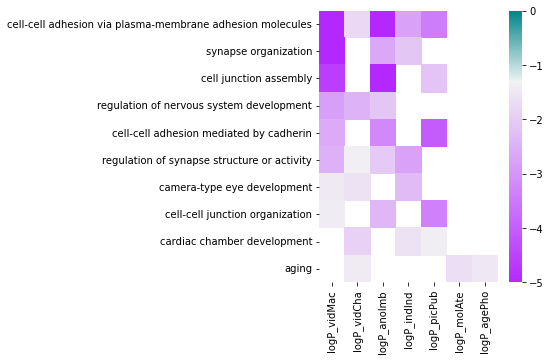

In [23]:
## purple color palette
cmap_pval = sns.diverging_palette(285, 200, 100, as_cmap=True)

## SF2
vmin = -5

divnorm_pval = DivergingNorm(vmin=vmin, vmax=0, vcenter=np.log10(0.051))

pval_cols = [i for i in merged_df.columns if i.startswith('logP_')]
df_pval = merged_df[pval_cols]

fig, axes = plt.subplots(figsize=(4, len(merged_df)/2))
sns.heatmap(data=df_pval, cmap=cmap_pval, norm=divnorm_pval)

axes.set_ylabel('')
fig.tight_layout()

pdf_name = 'noChildren.clusterProfiler.sweepFinder2.goenrich.7_lists.nonnectar.pdf'

# plt.savefig(pdf_name, format='pdf', bbox_inches="tight")